In [114]:
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd
import numpy as np

## Importing the DFs

In [103]:

gaming_companies = pd.read_csv("data/london_companies.csv")

schools = pd.read_csv("data/schools_df.csv")

starbucks = pd.read_csv("data/starbucks_df.csv")

design_companies = pd.read_csv("data/design_df.csv")


## Visualizing the Distribution of Companies in each Country

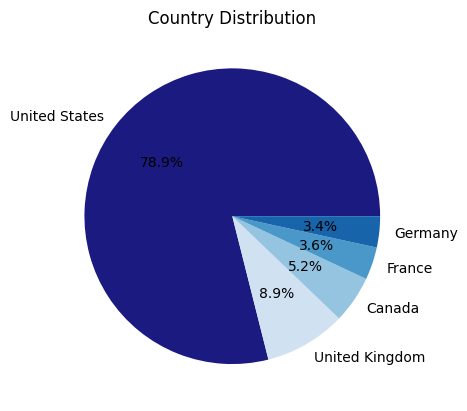

In [136]:
data = {'_id': ['[USA]', '[GBR]', '[CAN]', '[FRA]', '[DEU]'],
        'count': [487, 55, 32, 22, 21]}

df = pd.DataFrame(data)

country_mapping = {'[USA]': 'United States',
                   '[GBR]': 'United Kingdom',
                   '[CAN]': 'Canada',
                   '[FRA]': 'France',
                   '[DEU]': 'Germany'}

df = df.sort_values(by='count', ascending=False)

num_countries = len(df)
colors = [plt.cm.Blues(i / float(num_countries)) for i in range(num_countries)]

colors[0] = (0.1, 0.1, 0.5, 1.0) 

plt.pie(df['count'], labels=[country_mapping[code] for code in df['_id']], autopct='%1.1f%%', colors=colors)
plt.title('Country Distribution') 

country_distribution = "country_distribution.png"
plt.savefig(f"images/{country_distribution}")

plt.show()

## Visualizing the Distribution of Companies in each City of United Kingdom

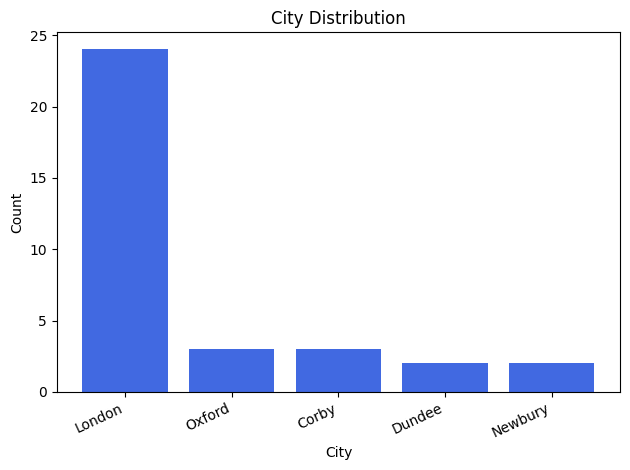

In [137]:
data = {'_id': ['[London]', '[Oxford]', '[Corby]', '[Dundee]', '[Newbury]'],
        'count': [24, 3, 3, 2, 2]}

df = pd.DataFrame(data)

cities = {'[London]': 'London',
          '[Oxford]': 'Oxford',
          '[Corby]': 'Corby',
          '[Dundee]': 'Dundee',
          '[Newbury]': 'Newbury'}

num_cities = len(df)

plt.bar(df['_id'].apply(lambda x: cities[x]), df['count'], color="royalblue")
plt.xlabel('City')
plt.ylabel('Count')
plt.title('City Distribution')

plt.xticks(rotation=25, ha='right')
plt.tight_layout()

city_distribution = "city_distribution.png"
plt.savefig(f"images/{city_distribution}")

plt.show()

## Creating the map with All the points in all DFs

In [135]:
def create_layers(map_, list_dfs, names_dfs):
    """
    Create layers for markers and heatmap based on the provided DataFrames.
    
    Args:
        map_ (folium.Map): The base map.
        list_dfs (list): List of DataFrames containing points of interest.
        names_dfs (list): List of names for the layers.
        
    Returns:
        list: List of layers to be added to the map.
    """
    
    layers = []  # List to store all layers
    heatmap_data = []  # List to store data for heatmap
    
    # Iterate over each DataFrame and its corresponding name
    
    for df, df_name in zip(list_dfs, names_dfs):
        layer = folium.FeatureGroup(name=f'{df_name}')  # Create a new layer for markers
        for _, row in df.iterrows():
            
            # Determine icon properties based on the DataFrame type
            
            if df.equals(gaming_companies):
                color = "red"
                icon_color = "white"
                icon = "gamepad"
            elif df.equals(schools):
                color = "blue"
                icon_color = "white"
                icon = "school-flag"
            elif df.equals(starbucks):
                color = "green"
                icon_color = "white"
                icon = "mug-hot"
            elif df.equals(design_companies):
                color = "orange"
                icon_color = "white"
                icon = "pen-nib"
                
            # Create marker with icon for each row in the DataFrame
            icon = folium.Icon(
                        color=color,
                        icon_color=icon_color,
                        icon=icon,
                        prefix="fa"
                )
            folium.Marker(location=[row['lat'], row['lon']], popup=row['name'], icon=icon).add_to(layer)
            
            # Add data for heatmap
            
            heatmap_data.append([row['lat'], row['lon'], 1])  # Each point appends its latitude, its longitude and assign 1 to
            # each point, that will be use in the future to select the point with more points near it
        
        layers.append(layer)  # Add marker layer to the list of layers
    
    # Create heatmap layer using the collected data
    
    heatmap_layer = HeatMap(heatmap_data, radius=15, name='Heat Map')
    layers.append(heatmap_layer)  # Add heatmap layer to the list of layers
    
    # Find the hottest coordinates in the heatmap
    
    max_intensity = max([point[2] for point in heatmap_data]) # this selects the maximum point with more values in the position [2], that will be 1 per point appended 
    hottest_coordinates = [[point[0], point[1]] for point in heatmap_data if point[2] == max_intensity]
    
    # Create a new layer for the top five points with more coincidences in the map
    
    hottest_points_layer = folium.FeatureGroup(name='Top 5')
    for i, coords in enumerate(hottest_coordinates[:5]):
        icon_top = folium.Icon(
                        color="red",
                        icon_color="white",
                        icon="fire",
                        prefix="fa"
                )
        folium.Marker(location=coords, popup=f'Hot Point {i+1}', icon=icon_top ).add_to(hottest_points_layer)
    layers.append(hottest_points_layer)  # Add the hottest points layer to the list of layers
    
    # Create a new layer for the hottest point
    
    best_company_layer = folium.FeatureGroup(name='Hottest spot')
    icon_best = folium.Icon(
                        color="darkred",
                        icon_color="white",
                        icon="trophy",
                        prefix="fa"
                )
            
    folium.Marker(location=hottest_coordinates[0], popup='Best Company', icon=icon_best).add_to(best_company_layer)
    layers.append(best_company_layer)  # Add the single hottest point layer to the list of layers
    
    
    return layers  # Return the list of layers

# Create the starting map

london_lat = 51.4991568
london_lon = -0.1908626
london_map = folium.Map(location=[london_lat, london_lon], zoom_start=12)

# List of DFs for the function. And list of names for the layers

list_dfs = [gaming_companies, starbucks, schools, design_companies] 
names_dfs = ['gaming companies', 'starbucks', 'schools', 'design companies']

# Create layers for each DataFrame in the list

layers = create_layers(london_map, list_dfs, names_dfs)

# Add each layer to the map

for layer in layers:
    layer.add_to(london_map)

# Add layer control to the map to select which layers to show

folium.LayerControl().add_to(london_map)


london_map
